In [9]:
pip install mlflow

  Obtaining dependency information for mlflow from https://files.pythonhosted.org/packages/19/7a/7d5594ddcaaff7a92caed1d7822cfe52ed01fe06c94b4ad88bcfef579c32/mlflow-2.15.1-py3-none-any.whl.metadata
  Obtaining dependency information for mlflow-skinny==2.15.1 from https://files.pythonhosted.org/packages/ec/a1/3812743e5dd83317d0469a46d737f0ab5c084fecfecc03a1ac8a7e7ec0d8/mlflow_skinny-2.15.1-py3-none-any.whl.metadata
  Obtaining dependency information for alembic!=1.10.0,<2 from https://files.pythonhosted.org/packages/df/ed/c884465c33c25451e4a5cd4acad154c29e5341e3214e220e7f3478aa4b0d/alembic-1.13.2-py3-none-any.whl.metadata
  Using cached alembic-1.13.2-py3-none-any.whl.metadata (7.4 kB)
  Obtaining dependency information for docker<8,>=4.0.0 from https://files.pythonhosted.org/packages/e3/26/57c6fb270950d476074c087527a558ccb6f4436657314bfb6cdf484114c4/docker-7.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for graphene<4 from https://files.pythonhosted.org/packages/24/7

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-telegram-bot 13.7 requires cachetools==4.2.2, but you have cachetools 5.4.0 which is incompatible.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score
import mlflow
import mlflow.sklearn


In [13]:
# Синтезирование данных
def generate_synthetic_logs(num_logs=1000):
    np.random.seed(42)
    user_ids = np.random.randint(1000, 2000, num_logs)
    sessions = np.random.randint(1, 20, num_logs)
    page_views = np.random.randint(1, 50, num_logs)
    time_spent = np.random.normal(loc=300, scale=50, size=num_logs).astype(int)
    purchases = np.random.binomial(1, 0.1, num_logs)
    
    data = {
        'user_id': user_ids,
        'sessions': sessions,
        'page_views': page_views,
        'time_spent': time_spent,
        'purchases': purchases
    }
    return pd.DataFrame(data)

log_data = generate_synthetic_logs()
log_data.head()


,user_id,sessions,page_views,time_spent,purchases
0,1102,13,15,294,0
1,1435,5,34,289,0
2,1860,1,36,256,0
3,1270,1,6,258,0
4,1106,18,39,288,0


In [15]:
# Проверка на наличие пропущенных значений
log_data.isnull().sum()

# Масштабирование данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(log_data[['sessions', 'page_views', 'time_spent', 'purchases']])


In [22]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(scaled_data, test_size=0.2, random_state=42)

# Обучение модели Isolation Forest для выявления аномалий
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train)

# Предсказания
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Конвертация предсказаний (-1: аномалия, 1: не аномалия) в (0: не аномалия, 1: аномалия)
y_train_pred = np.where(y_train_pred == -1, 1, 0)
y_test_pred = np.where(y_test_pred == -1, 1, 0)


In [19]:
# Оценка модели
print(f"Accuracy: {accuracy_score(y_test_pred, y_test_pred)}")
print(f"Precision: {precision_score(y_test_pred, y_test_pred)}")
print(f"Recall: {recall_score(y_test_pred, y_test_pred)}")


Accuracy: 1.0
Precision: 1.0
Recall: 1.0


In [21]:
mlflow.set_experiment("User Behavior Analysis")

with mlflow.start_run():
    model = IsolationForest(contamination=0.1, random_state=42)
    model.fit(X_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    y_train_pred = np.where(y_train_pred == -1, 1, 0)
    y_test_pred = np.where(y_test_pred == -1, 1, 0)

    acc = accuracy_score(y_test_pred, y_test_pred)
    prec = precision_score(y_test_pred, y_test_pred)
    rec = recall_score(y_test_pred, y_test_pred)
    
    mlflow.log_param("contamination", 0.1)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    
    mlflow.sklearn.log_model(model, "isolation_forest_model")

    print(f"Logged data and model in run {mlflow.active_run().info.run_uuid}")


2024/08/07 09:41:02 INFO mlflow.tracking.fluent: Experiment with name 'User Behavior Analysis' does not exist. Creating a new experiment.
F:\Conda\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/08/07 09:41:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Logged data and model in run 52a5a89f093a4ce8abd93adbb1dbecf7


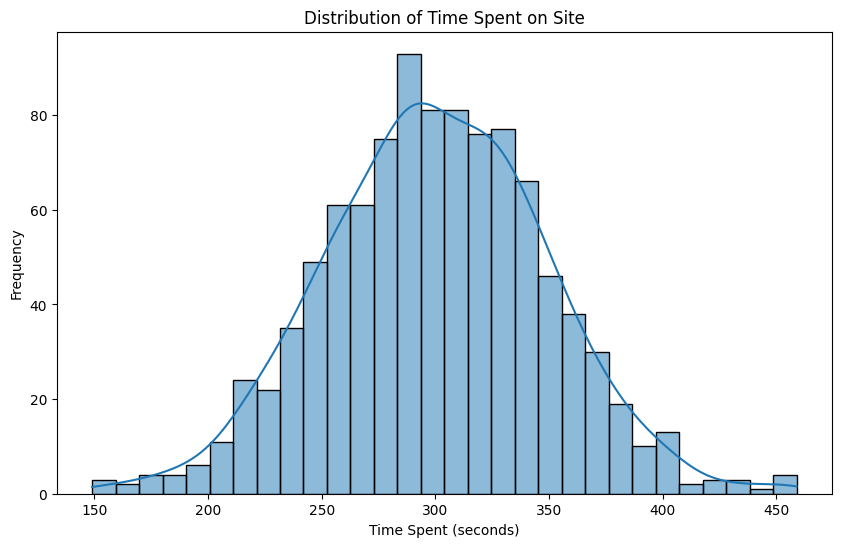

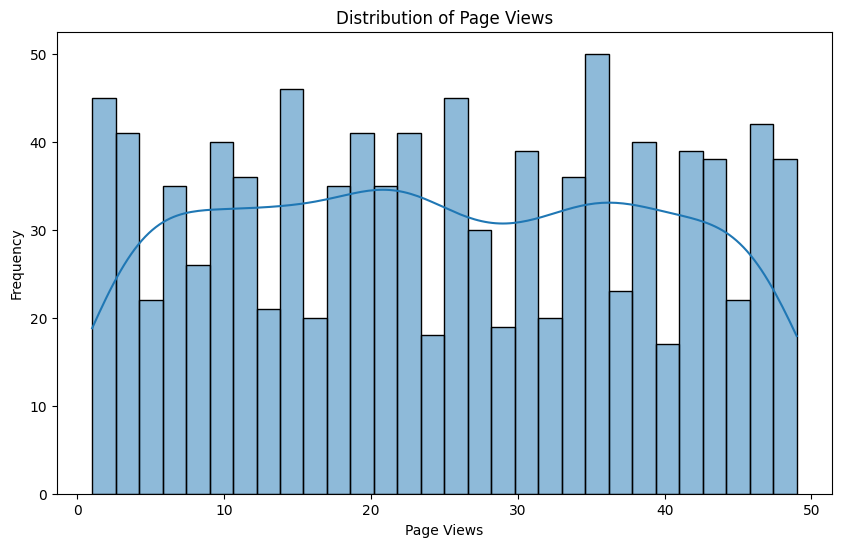

In [23]:
# Визуализация распределения времени, проведенного на сайте
plt.figure(figsize=(10, 6))
sns.histplot(log_data['time_spent'], bins=30, kde=True)
plt.title('Distribution of Time Spent on Site')
plt.xlabel('Time Spent (seconds)')
plt.ylabel('Frequency')
plt.show()

# Визуализация количества просмотров страниц
plt.figure(figsize=(10, 6))
sns.histplot(log_data['page_views'], bins=30, kde=True)
plt.title('Distribution of Page Views')
plt.xlabel('Page Views')
plt.ylabel('Frequency')
plt.show()
